In [1]:
import os
import sys
import warnings

os.chdir("../..")
sys.path.append("../../")
warnings.filterwarnings("ignore")

# Simulate datasets with condition effect

## Introduction

In this example, we will show how to use scDesign3Py to simulate data with condition effects and how to adjust the condition effects.

## Import packages and Read in data

### import pacakges

In [2]:
import copy
import anndata as ad
import numpy as np
import scDesign3Py

The R project used is located at /home/ld/anaconda3/envs/pyscdesign/lib/R


### Read in data

The raw data is from the `SeuratData` package. The data is called `ifnb` in the package; it is PBMC data simulated and controlled by IFNB. The raw data is converted to `.h5ad` file using the R package `sceasy`.

To save time, we only choose the top 30 genes and two cell types (CD14 Mono and B).

In [3]:
data = ad.read_h5ad("data/IFNB.h5ad")
data = data[(data.obs["cell_type"] == "CD14 Mono") | (data.obs["cell_type"] == "B"), 0:30]
data.layers["log"] = np.log1p(data.X)
data

AnnData object with n_obs × n_vars = 5340 × 30
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'ident', 'cell_type', 'condition'
    var: 'name'
    layers: 'log'

The condition information is stored in obs property of the example dataset.

In [6]:
data.obs["condition"].head()

AAACATACATTTCC.1    CTRL
AAACATACCAGAAA.1    CTRL
AAACATACCTCGCT.1    CTRL
AAACATACGGCATT.1    CTRL
AAACATTGCTTCGC.1    CTRL
Name: condition, dtype: category
Categories (2, object): ['CTRL', 'STIM']

## Simulation

First, we will simulate new data with the condition effects.

In [5]:
test = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")
test.set_r_random_seed(123)
simu_res = test.scdesign3(
    anndata=data,
    default_assay_name="counts",
    celltype="cell_type",
    other_covariates="condition",
    mu_formula="cell_type + condition + cell_type*condition",
    sigma_formula="1",
    family_use="nb",
    usebam=False,
    corr_formula="cell_type",
    copula="gaussian",
)
ifnb_newcount = simu_res["new_count"]

R[write to console]: Input Data Construction Start

R[write to console]: Input Data Construction End

R[write to console]: Start Marginal Fitting



  |=======================================================| 100%, Elapsed 00:13


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 00:03


R[write to console]: Converting End

R[write to console]: Copula group CD14 Mono starts

R[write to console]: Copula group B starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 00:02


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group CD14 Mono starts

R[write to console]: Sample Copula group B starts



  |=======================================================| 100%, Elapsed 00:00


R[write to console]: New Data Generating End



Then, we can also simulate a new dataset with condition effects on B cells removed.

In [6]:
# create instance
ifnb = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")

In [7]:
# construct data
ifnb_data = ifnb.construct_data(
    anndata=data,
    default_assay_name="counts",
    celltype = "cell_type",
    other_covariates = "condition",
    corr_formula = "cell_type"
)

In [8]:
# fit marginal
ifnb_marginal = ifnb.fit_marginal(
    mu_formula="cell_type + condition + cell_type*condition",
    sigma_formula="1",
    family_use="nb",
    usebam=False,
    n_cores=2
)

  |=======================================================| 100%, Elapsed 00:11


In [9]:
# fit copula
ifnb.set_r_random_seed(123)
ifnb_copula = ifnb.fit_copula()

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 00:03


R[write to console]: Converting End

R[write to console]: Copula group CD14 Mono starts

R[write to console]: Copula group B starts



In here, the condition effects on B cells are removed for all genes by modifying the estimated coefficients for all genes’ marginal models.

In [10]:
ifnb_marginal_null_B = copy.deepcopy(ifnb_marginal)
for k, _ in ifnb_marginal.items():
    ifnb_marginal.rx2(k).rx2("fit").rx2("coefficients")[-1] = 0 - ifnb_marginal.rx2(k).rx2(
        "fit"
    ).rx2("coefficients")[-2]

Then, we can generate the parameters using the altered marginal fits and simulate new data with the altered paremeters.

In [11]:
ifnb_para_null_B = ifnb.extract_para(
    marginal_dict=ifnb_marginal_null_B,
    family_use="nb",
    n_cores=2
)

  |=======================================================| 100%, Elapsed 00:01


In [12]:
ifnb.set_r_random_seed(123)
ifnb_newcount_null_B = ifnb.simu_new(n_cores=1)

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group CD14 Mono starts

R[write to console]: Sample Copula group B starts



  |=======================================================| 100%, Elapsed 00:01


We then create the corresponding `anndata.AnnData` object.

In [13]:
simu_anndata_list = []
for count_mat in [ifnb_newcount, ifnb_newcount_null_B]:
    tmp = ad.AnnData(X=count_mat, obs=ifnb_data["newCovariate"])
    tmp.layers["log"] = np.log1p(tmp.X)
    simu_anndata_list.append(tmp)

## Visulization

R[write to console]: Warning in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE,  :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

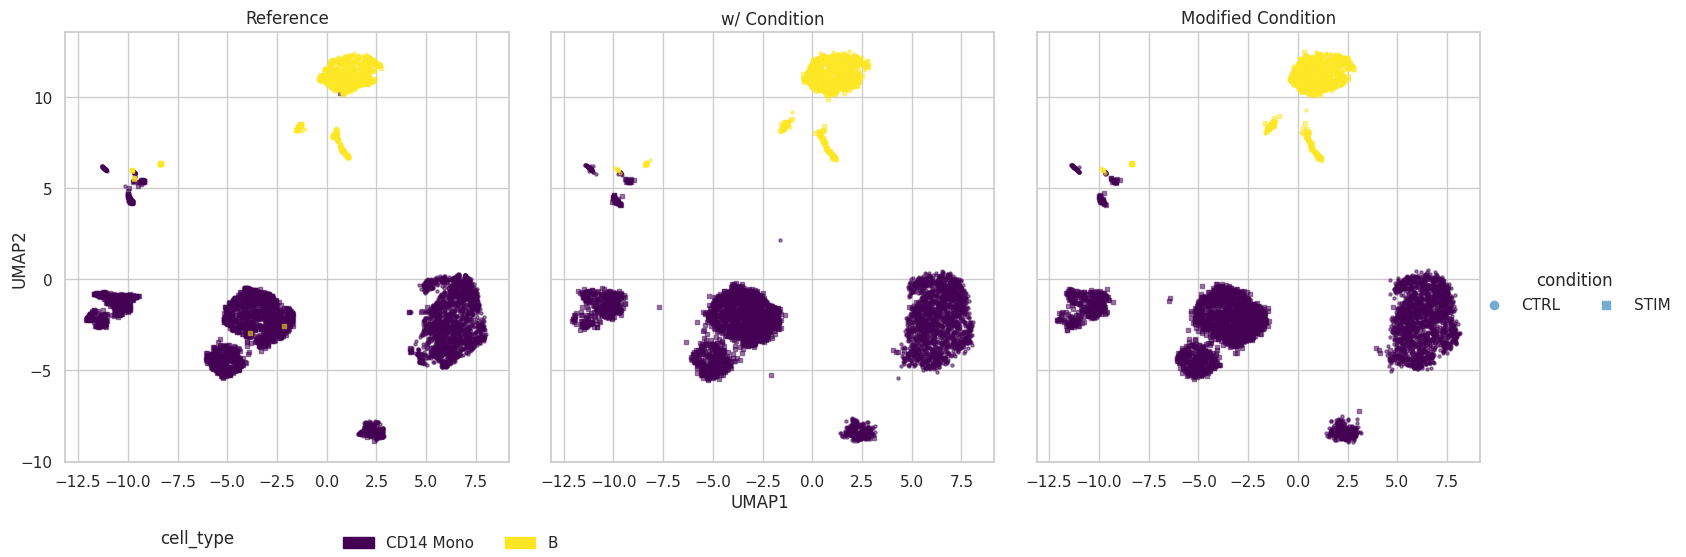

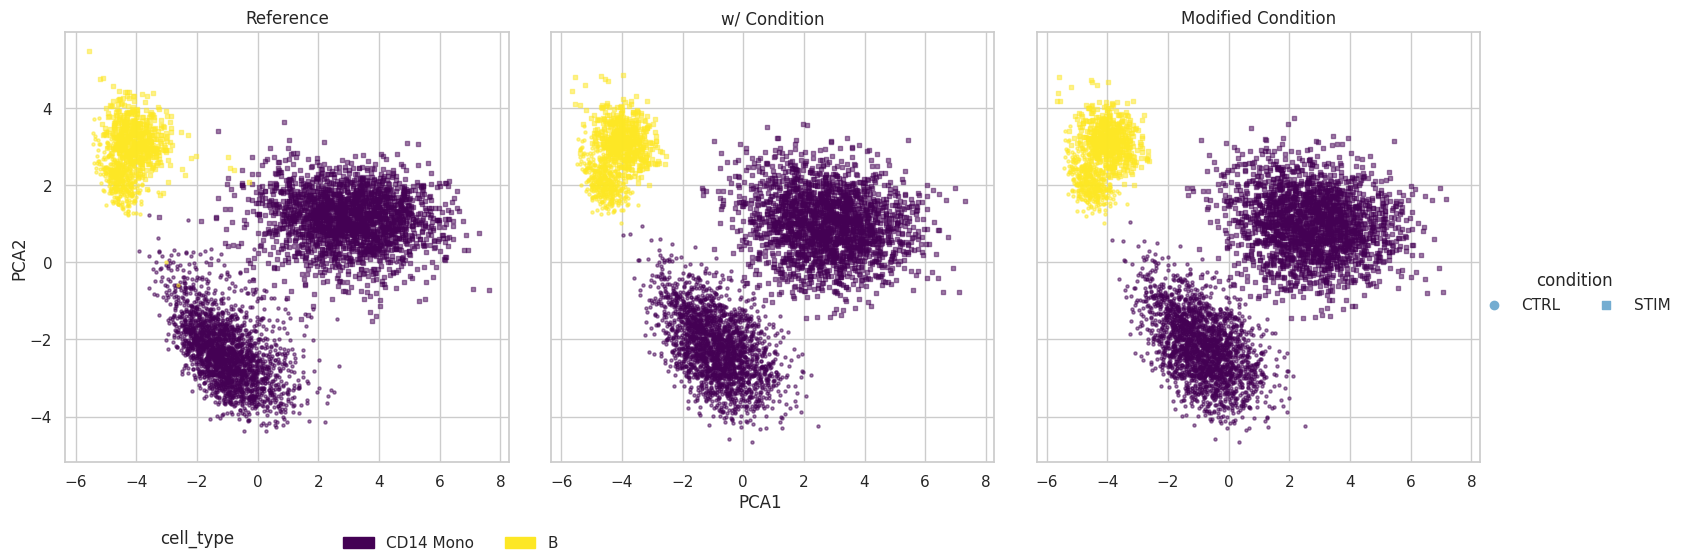

In [14]:
plot = scDesign3Py.plot_reduceddim(
    ref_anndata=data,
    anndata_list=simu_anndata_list,
    name_list=["Reference", "w/ Condition", "Modified Condition"],
    assay_use="log",
    color_by="cell_type",
    shape_by="condition",
    n_pc=20,
    point_size=5,
)

### UMAP

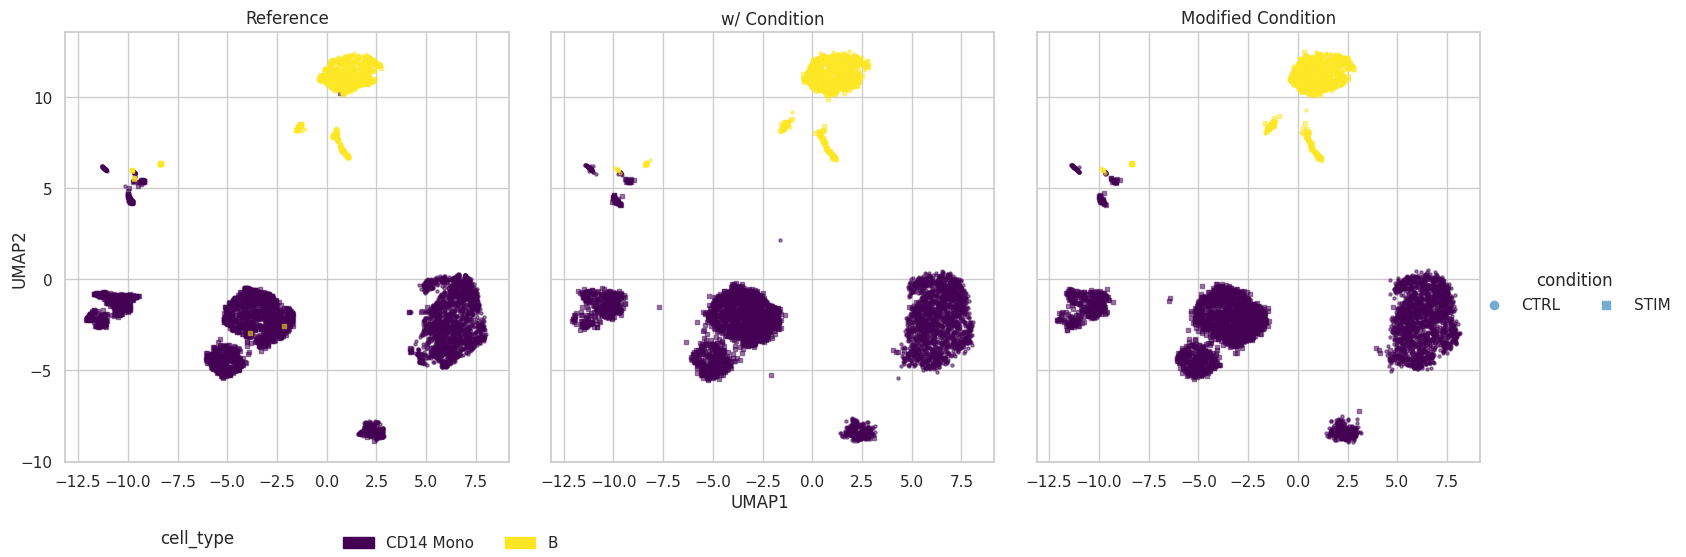

In [15]:
plot["p_umap"]